In [2]:
pip install prophet

     |████████████████████████████████| 8.8 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [32]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import prophet

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [29]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# data prep

In [9]:
east = pd.read_csv('data/east_daily.csv', index_col=0, parse_dates=[0])
midwest = pd.read_csv('data/midwest_daily.csv', index_col=0, parse_dates=[0]) 
south = pd.read_csv('data/south_daily.csv', index_col=0, parse_dates=[0]) 
west = pd.read_csv('data/west_daily.csv', index_col=0, parse_dates=[0]) 

In [12]:
east = east.sort_index()
midwest = midwest.sort_index()
south = south.sort_index()
west = west.sort_index()

In [313]:
train_size = int(len(east) * 0.9)

east_train, east_test = east[0:train_size], east[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest[0:train_size], midwest[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south[0:train_size], south[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west[0:train_size], west[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [202]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-02-12,NaN,0.0
2020-02-13,NaN,0.0
2020-02-14,NaN,0.0
2020-02-15,NaN,0.0
2020-02-16,NaN,0.0
...,...,...
2023-03-19,0.0,NaN
2023-03-20,37.0,NaN
2023-03-21,33.0,NaN


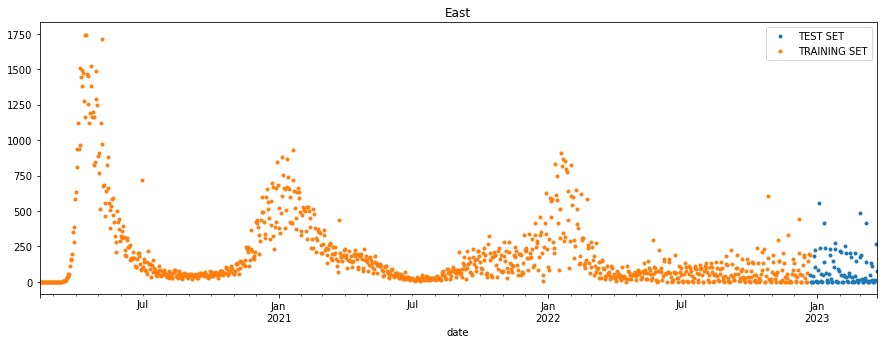

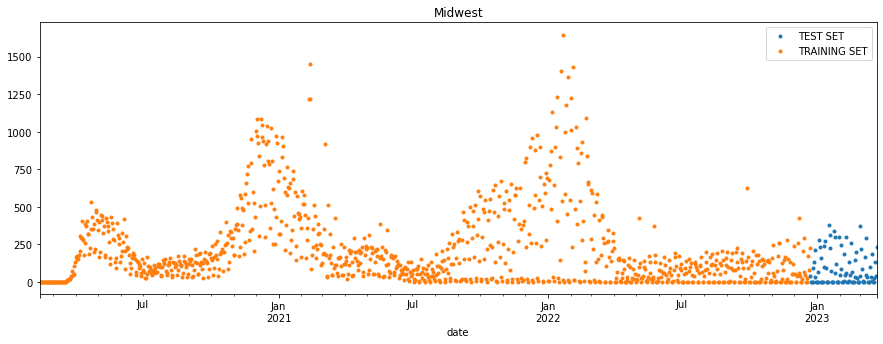

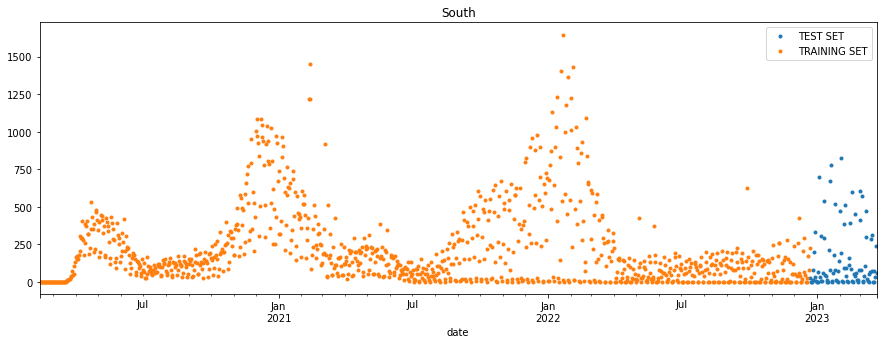

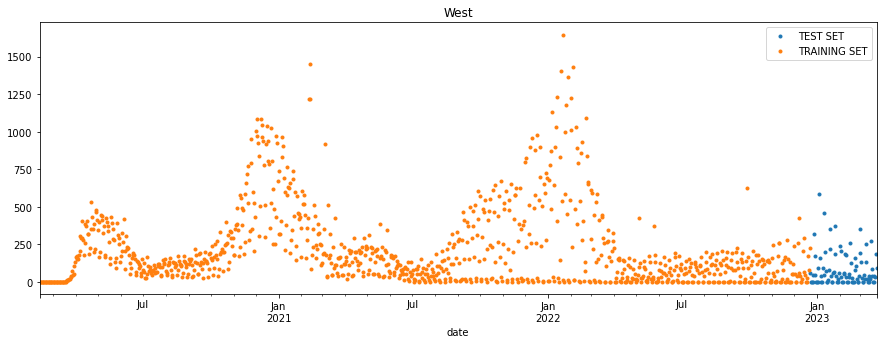

In [203]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Midwest', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='South', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='West', style='.')

# Univariate Prophet

### east

In [314]:
east_model = prophet.Prophet().fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))



03:05:56 - cmdstanpy - INFO - Chain [1] start processing
03:05:56 - cmdstanpy - INFO - Chain [1] done processing


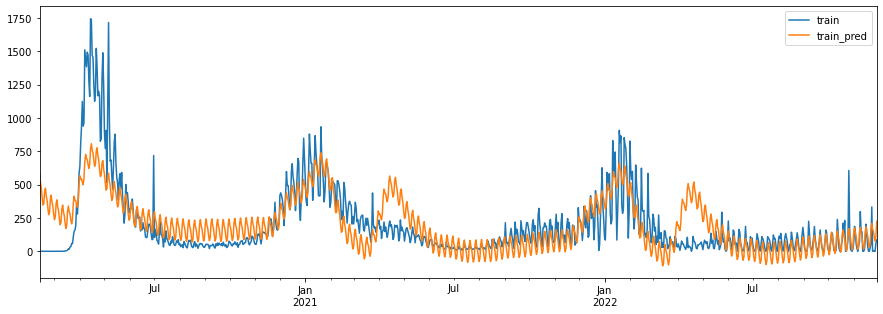

Training Set Metrics:
MAE: 126.31169182411163
MASE: 0.0005386064020969436


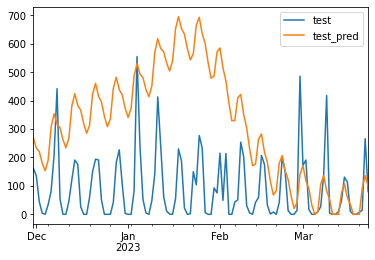

Testing Set Metrics:
MAE: 242.5279650823465
MASE: 0.008174503612576286


In [315]:
train_pred=east_model.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

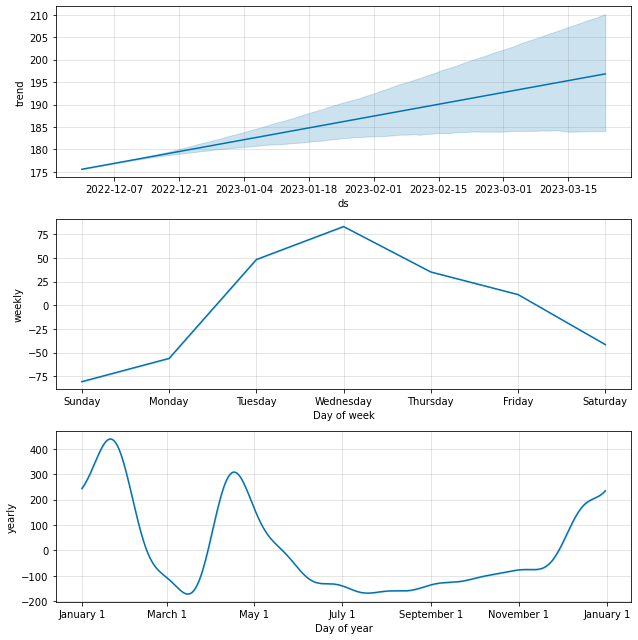

In [316]:
test_pred = test_pred.reset_index()

fig = east_model.plot_components(test_pred)
plt.show()

In [422]:
east_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

east_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # decrease weekly (default is 3)
east_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 

east_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:28:12 - cmdstanpy - INFO - Chain [1] start processing
03:28:12 - cmdstanpy - INFO - Chain [1] done processing


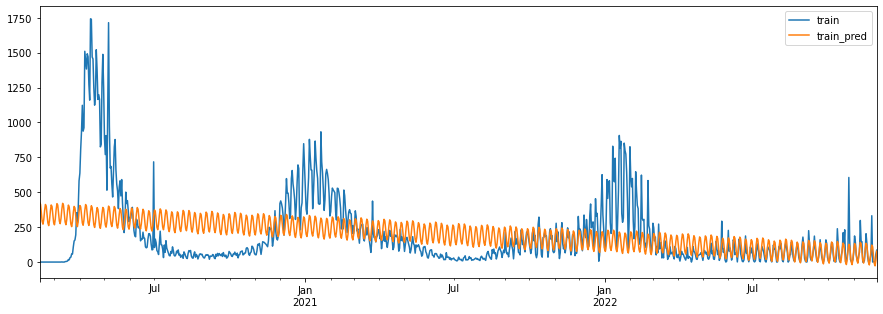

Training Set Metrics:
MAE: 158.86615366461862
MASE: 0.0007987154721858529


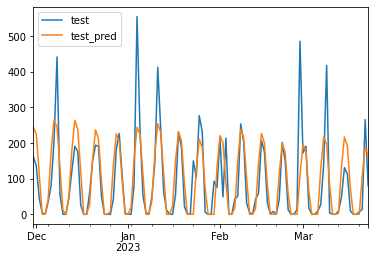

Testing Set Metrics:
MAE: 45.44767698379004
MASE: 0.0036194239688761456


In [421]:
train_pred=east_model2.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model2.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

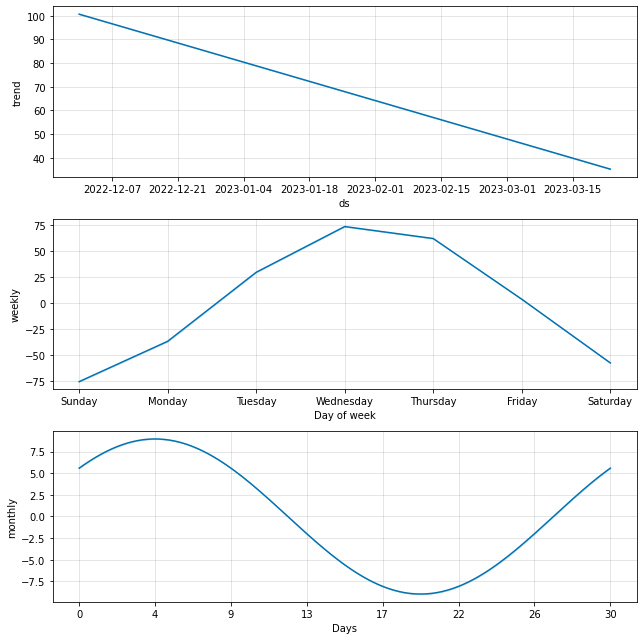

In [319]:
test_pred = test_pred.reset_index()

fig = east_model2.plot_components(test_pred)
plt.show()

### midwest

In [120]:
midwest_model = prophet.Prophet().fit(midwest_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing


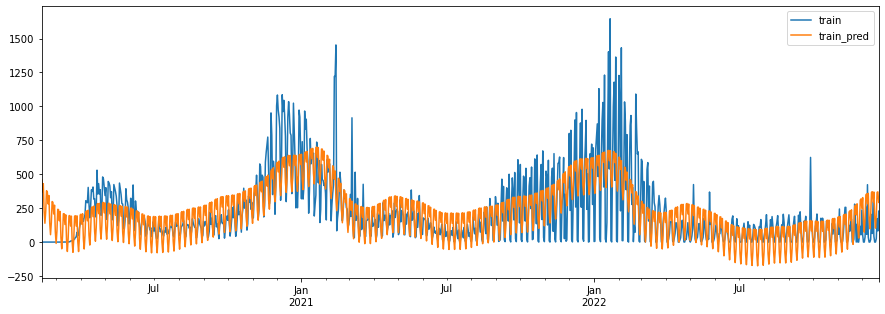

Training Set Metrics:
MAE: 123.46899038751779
MASE: 0.0005039781034335188


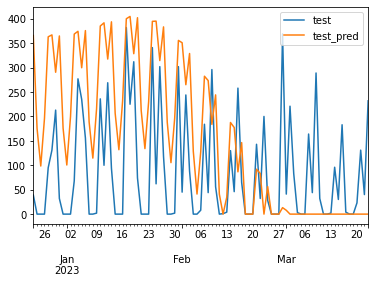

Testing Set Metrics:
MAE: 124.93075155778845
MASE: 0.009188716178868244


In [121]:
train_pred=midwest_model.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

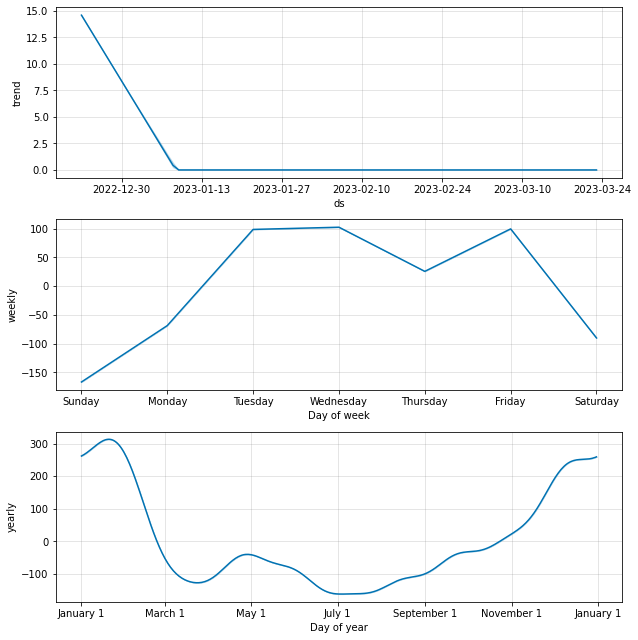

In [122]:
test_pred = test_pred.reset_index()

fig = midwest_model.plot_components(test_pred)
plt.show()

In [418]:
midwest_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

midwest_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
midwest_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 

midwest_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:27:39 - cmdstanpy - INFO - Chain [1] start processing
03:27:39 - cmdstanpy - INFO - Chain [1] done processing


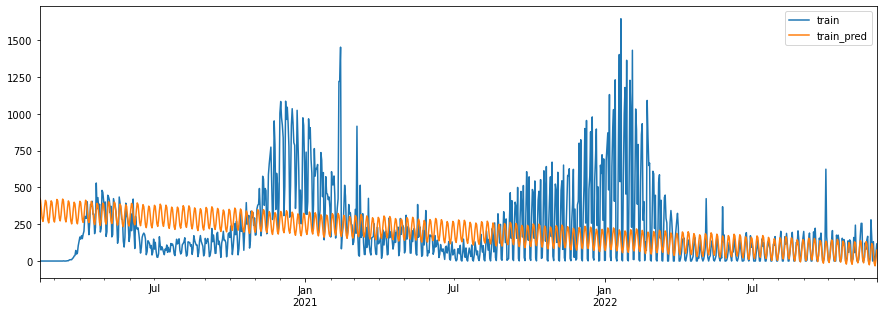

Training Set Metrics:
MAE: 164.73294139440995
MASE: 0.000813770476267849


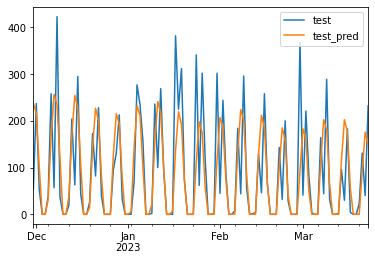

Testing Set Metrics:
MAE: 50.472215964858194
MASE: 0.004138515629691905


In [419]:
train_pred=midwest_model2.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model2.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [423]:
south_model = prophet.Prophet().fit(south_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:28:18 - cmdstanpy - INFO - Chain [1] start processing
03:28:19 - cmdstanpy - INFO - Chain [1] done processing


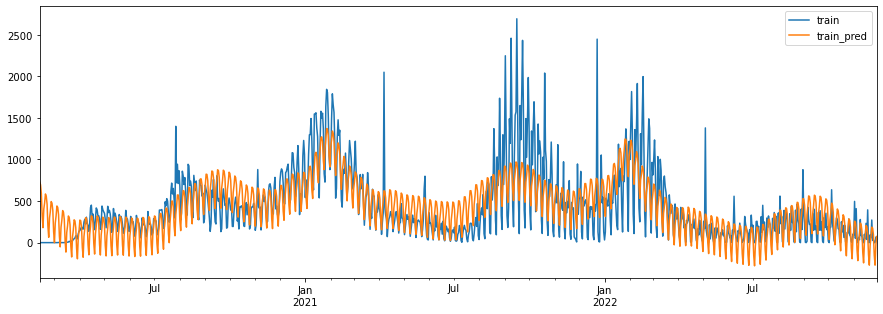

Training Set Metrics:
MAE: 208.75841189868515
MASE: 0.0005076086356317453


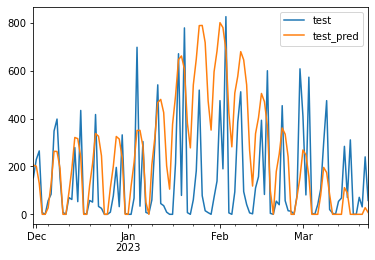

Testing Set Metrics:
MAE: 181.15935254019678
MASE: 0.006491558502120127


In [424]:
train_pred=south_model.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

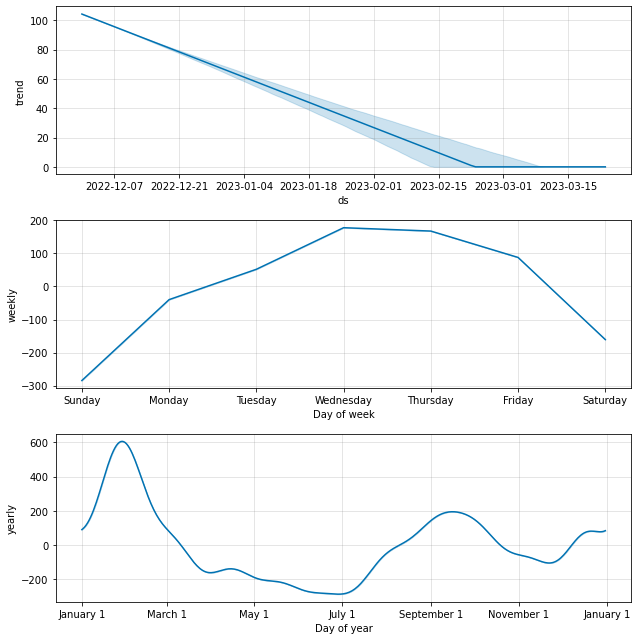

In [425]:
test_pred = test_pred.reset_index()

fig = south_model.plot_components(test_pred)
plt.show()

In [426]:
south_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

south_model2.add_seasonality(name='weekly', period=7, fourier_order=8, prior_scale = 20) # add weekly (default is 3)
south_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 

south_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:28:22 - cmdstanpy - INFO - Chain [1] start processing
03:28:22 - cmdstanpy - INFO - Chain [1] done processing


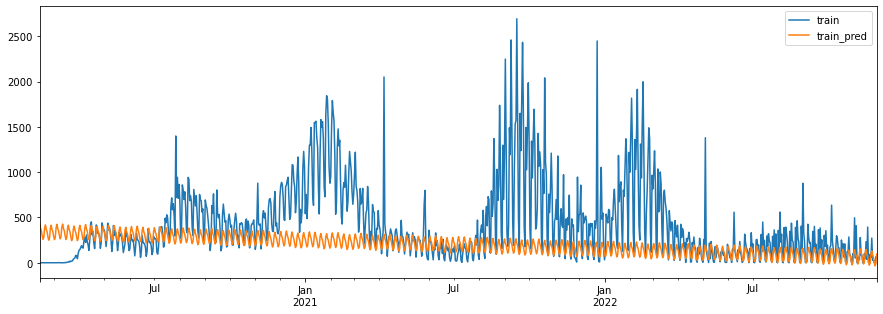

Training Set Metrics:
MAE: 290.32470730337747
MASE: 0.0008735356387037365


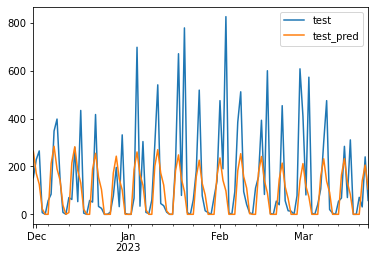

Testing Set Metrics:
MAE: 101.70273626643025
MASE: 0.00562502567761799


In [427]:
train_pred=south_model2.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model2.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [428]:
west_model = prophet.Prophet().fit(west_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:29:12 - cmdstanpy - INFO - Chain [1] start processing
03:29:12 - cmdstanpy - INFO - Chain [1] done processing


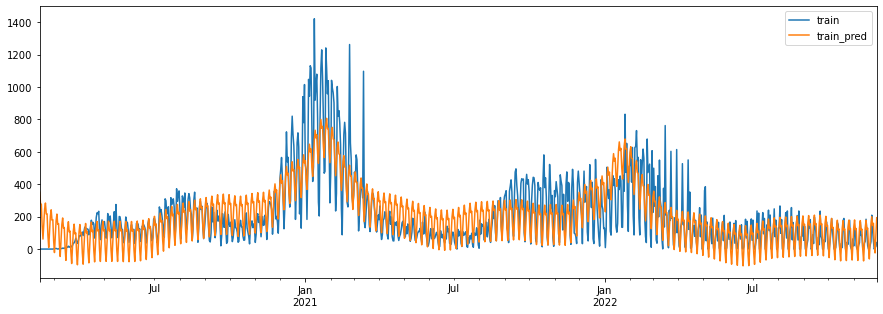

Training Set Metrics:
MAE: 95.048850991629
MASE: 0.0004682512001673937


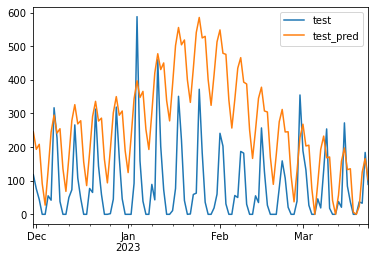

Testing Set Metrics:
MAE: 189.11045001820386
MASE: 0.007810493804211584


In [429]:
train_pred=west_model.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

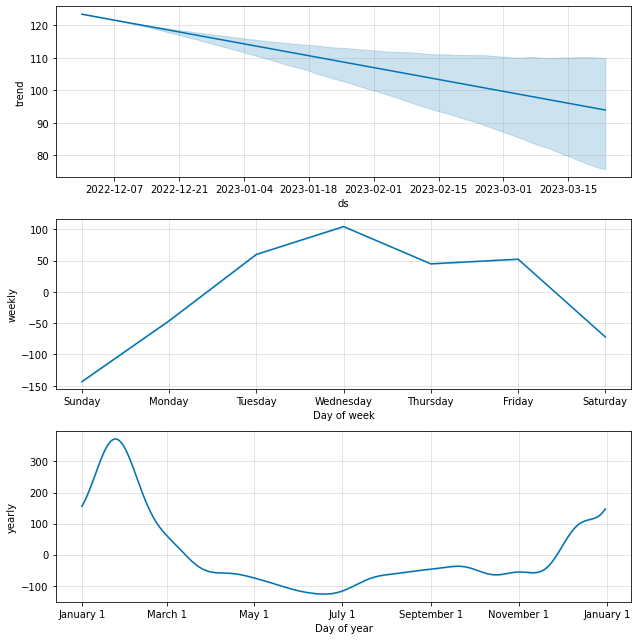

In [430]:
test_pred = test_pred.reset_index()

fig = west_model.plot_components(test_pred)
plt.show()

In [431]:
west_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

west_model2.add_seasonality(name='weekly', period=7, fourier_order=8, prior_scale = 20) # add weekly (default is 3)
west_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 
west_model2.add_seasonality(name='yearly', period=365, fourier_order=1, prior_scale = 0.001) 

west_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:29:14 - cmdstanpy - INFO - Chain [1] start processing
03:29:14 - cmdstanpy - INFO - Chain [1] done processing


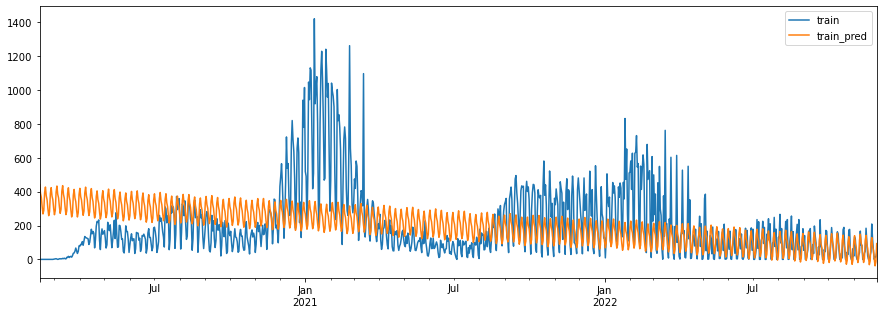

Training Set Metrics:
MAE: 148.00749813314334
MASE: 0.0008358238913086887


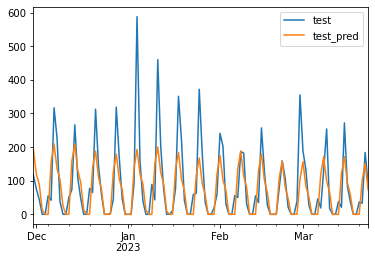

Testing Set Metrics:
MAE: 49.1394991030547
MASE: 0.0045657613929406355


In [432]:
train_pred=west_model2.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model2.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)